# NutriSense-AI — Image Classifier (EfficientNetB4) 
(This notebook was run in kaggle to use GPU for training)

This notebook:
- Trains (or loads) EfficientNetB4 model on the `images/` folder where each subfolder is a class.
- Runs inference on a sample image and returns the folder name (predicted dish).



In [28]:

import os
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, "/kaggle/working/SRC")
from model_utils import build_efficientnetb4, get_callbacks
from Src.Image_classifier.data_loader import make_datasets
from Src.Image_classifier.Inference import load_model_and_meta, predict_image




In [39]:
import os
import json
from PIL import Image
import tensorflow as tf
from pathlib import Path

# ============ PATHS ============
PROJECT_ROOT = Path('/kaggle/input/nutrisense-ai/NutriSense-AI')
IMAGE_DIR_INPUT = str(PROJECT_ROOT / 'Dataset' / 'Images')  # Original (read-only)
IMAGE_DIR_CLEAN = '/kaggle/working/images_cleaned'  # Cleaned copy (writable)

SAVE_DIR = '/kaggle/working/models'
os.makedirs(SAVE_DIR, exist_ok=True)

MODEL_PATH = os.path.join(SAVE_DIR, 'efficientb4_best.h5')
META_PATH = os.path.join(SAVE_DIR, 'meta.json')

IMG_SIZE = 256
BATCH_SIZE = 16

# ============ STEP 1: CREATE CLEANED DATASET ============
print("Creating cleaned dataset...")
os.makedirs(IMAGE_DIR_CLEAN, exist_ok=True)

cleaned_count = 0
skipped_count = 0

for root, dirs, files in os.walk(IMAGE_DIR_INPUT):
    # Get class name from folder
    class_name = os.path.basename(root)
    class_output_dir = os.path.join(IMAGE_DIR_CLEAN, class_name)
    
    if not os.path.exists(class_output_dir) and class_name != 'Images':
        os.makedirs(class_output_dir, exist_ok=True)
    
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
            src_path = os.path.join(root, file)
            dst_path = os.path.join(class_output_dir, file)
            
            # Check if image is valid
            try:
                # Try PIL
                img = Image.open(src_path)
                img.verify()
                
                # Try TensorFlow decode
                raw = tf.io.read_file(src_path)
                if file.lower().endswith(('.png', '.PNG')):
                    _ = tf.image.decode_png(raw, channels=3)
                else:
                    _ = tf.image.decode_jpeg(raw, channels=3)
                
                # If both pass, copy to cleaned dir
                import shutil
                shutil.copy2(src_path, dst_path)
                cleaned_count += 1
                
            except Exception as e:
                # Skip corrupt images
                skipped_count += 1
                if cleaned_count % 1000 == 0:
                    print(f"  Skipped: {skipped_count} corrupt files so far...")

print(f"\n✓ Cleanup complete!")
print(f"  Copied: {cleaned_count} valid images")
print(f"  Skipped: {skipped_count} corrupt images")
print(f"  Cleaned dataset at: {IMAGE_DIR_CLEAN}")

Creating cleaned dataset...

✓ Cleanup complete!
  Copied: 20136 valid images
  Skipped: 192 corrupt images
  Cleaned dataset at: /kaggle/working/images_cleaned


In [29]:
import sys, torch
print("Python:", sys.executable)
print("Torch:", torch.__version__)
print("File:", torch.__file__)


Python: /usr/bin/python3
Torch: 2.6.0+cu124
File: /usr/local/lib/python3.11/dist-packages/torch/__init__.py


In [30]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


True
2
Tesla T4


In [31]:
import tensorflow as tf
print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))


TF version: 2.18.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [ ]:
train_flag = False  # set True to train (may take long)

if train_flag:
    train_ds, val_ds, class_names = make_datasets(
        IMAGE_DIR_CLEAN,
        img_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        val_split=0.2
    )

    # ADD PREPROCESSING HERE (REQUIRED for Fix 1)
    def preprocess_image(img, label):
        img = tf.keras.applications.efficientnet.preprocess_input(img)
        return img, label

    train_ds = train_ds.map(
        preprocess_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    val_ds = val_ds.map(
        preprocess_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
    val_ds   = val_ds.prefetch(tf.data.AUTOTUNE)
    # --------------------------------------------------

    model = build_efficientnetb4(
        num_classes=len(class_names),
        img_size=(IMG_SIZE, IMG_SIZE)
    )

    callbacks = get_callbacks(
        save_dir=SAVE_DIR,
        model_name='efficientb4_best.h5',
        patience=5
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=15,
        callbacks=callbacks
    )

    model.save(os.path.join(SAVE_DIR, 'efficientb4_final.h5'))

    meta = {
        'class_names': class_names,
        'img_size': IMG_SIZE,
        'num_classes': len(class_names)
    }

    with open(META_PATH, 'w') as f:
        json.dump(meta, f)

else:
    print("Skipping training. Make sure MODEL_PATH and META_PATH exist.")


Found 20136 files belonging to 148 classes.
Using 16109 files for training.
Found 20136 files belonging to 148 classes.
Using 4027 files for validation.
Found 20136 files belonging to 148 classes.
Epoch 1/15
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.1038 - loss: 4.5610
Epoch 1: val_loss improved from inf to 3.36669, saving model to /kaggle/working/models/efficientb4_best.h5


1007/1007 ━━━━━━━━━━━━━━━━━━━━ 180s 136ms/step - accuracy: 0.1039 - loss: 4.5606 - val_accuracy: 0.3906 - val_loss: 3.3667 - learning_rate: 1.0000e-04
Epoch 2/15
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4080 - loss: 3.1104
Epoch 2: val_loss improved from 3.36669 to 2.51842, saving model to /kaggle/working/models/efficientb4_best.h5


1007/1007 ━━━━━━━━━━━━━━━━━━━━ 73s 73ms/step - accuracy: 0.4081 - loss: 3.1102 - val_accuracy: 0.5232 - val_loss: 2.5184 - learning_rate: 1.0000e-04
Epoch 3/15
1006/1007 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5451 - loss: 2.3599
Epoch 3: val_loss improved from 2.51842 to 2.05181, saving model to /kaggle/working/models/efficientb4_best.h5


1007/1007 ━━━━━━━━━━━━━━━━━━━━ 73s 72ms/step - accuracy: 0.5451 - loss: 2.3597 - val_accuracy: 0.5987 - val_loss: 2.0518 - learning_rate: 1.0000e-04
Epoch 4/15
1006/1007 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6049 - loss: 1.9476
Epoch 4: val_loss improved from 2.05181 to 1.77272, saving model to /kaggle/working/models/efficientb4_best.h5


1007/1007 ━━━━━━━━━━━━━━━━━━━━ 73s 72ms/step - accuracy: 0.6049 - loss: 1.9475 - val_accuracy: 0.6340 - val_loss: 1.7727 - learning_rate: 1.0000e-04
Epoch 5/15
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6472 - loss: 1.6796
Epoch 5: val_loss improved from 1.77272 to 1.59175, saving model to /kaggle/working/models/efficientb4_best.h5


1007/1007 ━━━━━━━━━━━━━━━━━━━━ 73s 72ms/step - accuracy: 0.6472 - loss: 1.6796 - val_accuracy: 0.6595 - val_loss: 1.5918 - learning_rate: 1.0000e-04
Epoch 6/15
1006/1007 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6790 - loss: 1.5020
Epoch 6: val_loss improved from 1.59175 to 1.46386, saving model to /kaggle/working/models/efficientb4_best.h5


1007/1007 ━━━━━━━━━━━━━━━━━━━━ 72s 72ms/step - accuracy: 0.6790 - loss: 1.5019 - val_accuracy: 0.6797 - val_loss: 1.4639 - learning_rate: 1.0000e-04
Epoch 7/15
1006/1007 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6958 - loss: 1.3800
Epoch 7: val_loss improved from 1.46386 to 1.36934, saving model to /kaggle/working/models/efficientb4_best.h5


1007/1007 ━━━━━━━━━━━━━━━━━━━━ 72s 72ms/step - accuracy: 0.6959 - loss: 1.3799 - val_accuracy: 0.6884 - val_loss: 1.3693 - learning_rate: 1.0000e-04
Epoch 8/15
1006/1007 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7101 - loss: 1.2813
Epoch 8: val_loss improved from 1.36934 to 1.29615, saving model to /kaggle/working/models/efficientb4_best.h5


1007/1007 ━━━━━━━━━━━━━━━━━━━━ 72s 72ms/step - accuracy: 0.7101 - loss: 1.2812 - val_accuracy: 0.7000 - val_loss: 1.2962 - learning_rate: 1.0000e-04
Epoch 9/15
1006/1007 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7298 - loss: 1.1919
Epoch 9: val_loss improved from 1.29615 to 1.23895, saving model to /kaggle/working/models/efficientb4_best.h5


1007/1007 ━━━━━━━━━━━━━━━━━━━━ 72s 72ms/step - accuracy: 0.7298 - loss: 1.1919 - val_accuracy: 0.7082 - val_loss: 1.2389 - learning_rate: 1.0000e-04
Epoch 10/15
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7385 - loss: 1.1255
Epoch 10: val_loss improved from 1.23895 to 1.19206, saving model to /kaggle/working/models/efficientb4_best.h5


1007/1007 ━━━━━━━━━━━━━━━━━━━━ 72s 72ms/step - accuracy: 0.7385 - loss: 1.1254 - val_accuracy: 0.7107 - val_loss: 1.1921 - learning_rate: 1.0000e-04
Epoch 11/15
1006/1007 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7536 - loss: 1.0696
Epoch 11: val_loss improved from 1.19206 to 1.15246, saving model to /kaggle/working/models/efficientb4_best.h5


1007/1007 ━━━━━━━━━━━━━━━━━━━━ 72s 72ms/step - accuracy: 0.7536 - loss: 1.0696 - val_accuracy: 0.7134 - val_loss: 1.1525 - learning_rate: 1.0000e-04
Epoch 12/15
1006/1007 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7655 - loss: 1.0213
Epoch 12: val_loss improved from 1.15246 to 1.11757, saving model to /kaggle/working/models/efficientb4_best.h5


1007/1007 ━━━━━━━━━━━━━━━━━━━━ 72s 72ms/step - accuracy: 0.7655 - loss: 1.0213 - val_accuracy: 0.7184 - val_loss: 1.1176 - learning_rate: 1.0000e-04
Epoch 13/15
1006/1007 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7736 - loss: 0.9772
Epoch 13: val_loss improved from 1.11757 to 1.08911, saving model to /kaggle/working/models/efficientb4_best.h5


1007/1007 ━━━━━━━━━━━━━━━━━━━━ 72s 72ms/step - accuracy: 0.7736 - loss: 0.9772 - val_accuracy: 0.7246 - val_loss: 1.0891 - learning_rate: 1.0000e-04
Epoch 14/15
1006/1007 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7800 - loss: 0.9422
Epoch 14: val_loss improved from 1.08911 to 1.06429, saving model to /kaggle/working/models/efficientb4_best.h5


1007/1007 ━━━━━━━━━━━━━━━━━━━━ 72s 72ms/step - accuracy: 0.7800 - loss: 0.9422 - val_accuracy: 0.7298 - val_loss: 1.0643 - learning_rate: 1.0000e-04
Epoch 15/15
1006/1007 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7905 - loss: 0.9018
Epoch 15: val_loss improved from 1.06429 to 1.04098, saving model to /kaggle/working/models/efficientb4_best.h5


1007/1007 ━━━━━━━━━━━━━━━━━━━━ 72s 72ms/step - accuracy: 0.7905 - loss: 0.9018 - val_accuracy: 0.7323 - val_loss: 1.0410 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 15.


In [41]:
MODEL_PATH = '/kaggle/working/models/efficientb4_best.h5'
META_PATH  = '/kaggle/working/models/meta.json'

if not os.path.exists(MODEL_PATH) or not os.path.exists(META_PATH):
    raise FileNotFoundError("Model or meta not found.")

model, meta = load_model_and_meta(MODEL_PATH, META_PATH)

print("Loaded model. Number of classes:", meta["num_classes"])


Loaded model. Number of classes: 148


In [48]:
# pick a sample image (adjust path)
sample_img = "/kaggle/input/test-image/dosa_test.webp"  # replace with your test image path
if not os.path.exists(sample_img):
    # pick one random image from images folder for demo
    # find first image in dataset
    for root, dirs, files in os.walk(IMAGE_DIR):
        for f in files:
            if f.lower().endswith(('.jpg','.jpeg','.png')):
                sample_img = os.path.join(root, f)
                break
        if os.path.exists(sample_img):
            break

print("Using:", sample_img)
res = predict_image(model, meta, sample_img, top_k=3)
res


Using: /kaggle/input/test-image/dosa_test.webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[{'label_index': 122, 'label': 'rasgulla', 'score': 0.44910016655921936},
 {'label_index': 75, 'label': 'kulfi', 'score': 0.28558245301246643},
 {'label_index': 15, 'label': 'besan laddu', 'score': 0.022298553958535194}]

## Evaluation
We will run evaluation on the validation split and print:
- Top-1 accuracy
- Top-3 accuracy
- Macro & Micro F1
- Classification report (as a DataFrame)
- Top 15 classes by per-class accuracy and bottom 15
- Confusion matrix


In [49]:
# Evaluation settings (change if desired)
TOP_K = 3
BATCH_SIZE = 32
VAL_SPLIT = 0.2

# Ensure these variables are defined from earlier cells:
# IMAGE_DIR, model, IMG_SIZE, meta (meta['class_names'])
class_names = meta['class_names']


In [52]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import display
from Src.Image_classifier.data_loader import make_datasets

# Build validation dataset
_, val_ds, _ = make_datasets(IMAGE_DIR_CLEAN, img_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, val_split=VAL_SPLIT)

y_true = []
y_pred = []
y_probs = []

print("Running inference on validation split... (this may take a moment)")
for batch_imgs, batch_labels in val_ds:
    probs = model.predict(batch_imgs)
    preds = probs.argmax(axis=1)
    y_true.extend(batch_labels.numpy().tolist())
    y_pred.extend(preds.tolist())
    y_probs.extend(probs.tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs)
print("Done. Total validation samples:", len(y_true))


Found 20136 files belonging to 148 classes.
Using 16109 files for training.
Found 20136 files belonging to 148 classes.
Using 4027 files for validation.
Found 20136 files belonging to 148 classes.
Running inference on validation split... (this may take a moment)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/s

In [53]:
# Top-1 accuracy
top1 = accuracy_score(y_true, y_pred)

# Top-k accuracy
def top_k_acc(y_true, y_probs, k=3):
    topk = np.argsort(y_probs, axis=1)[:, -k:][:, ::-1]
    hits = sum(1 if y_true[i] in topk[i] else 0 for i in range(len(y_true)))
    return hits / len(y_true)

topk = top_k_acc(y_true, y_probs, k=TOP_K)

macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
micro_f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)

print(f"Top-1 accuracy: {top1:.4f}")
print(f"Top-{TOP_K} accuracy: {topk:.4f}")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Micro F1: {micro_f1:.4f}")
print()


Top-1 accuracy: 0.6797
Top-3 accuracy: 0.8520
Macro F1: 0.6796
Micro F1: 0.6797



In [54]:
# Classification report (as DataFrame)
report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0, output_dict=True)
import pandas as pd
report_df = pd.DataFrame(report).transpose()

# Show main metrics for classes (precision, recall, f1-score, support)
pd.set_option('display.max_rows', 200)
display(report_df.loc[[c for c in report_df.index if c not in ('accuracy','macro avg','weighted avg','micro avg')], ['precision','recall','f1-score','support']])

# Per-class accuracy
per_class_acc = {}
for i, cname in enumerate(class_names):
    idx = np.where(y_true == i)[0]
    per_class_acc[cname] = None if len(idx) == 0 else float((y_pred[idx] == i).sum()) / len(idx)

per_class_series = pd.Series(per_class_acc).sort_values(ascending=False)

print("\nTop 15 classes by accuracy:")
display(per_class_series.head(15))

print("\nBottom 15 classes by accuracy (might be empty if few classes):")
display(per_class_series.tail(15))


,precision,recall,f1-score,support
achar,0.846154,0.478261,0.611111,23.0
aloo gobi,0.400000,0.461538,0.428571,26.0
aloo matar,0.555556,0.777778,0.648148,45.0
aloo methi,0.764706,0.565217,0.650000,23.0
aloo puri,0.650000,0.866667,0.742857,15.0
aloo tikki,0.500000,0.520000,0.509804,25.0
appam,0.833333,0.454545,0.588235,22.0
apple,1.000000,0.727273,0.842105,11.0
apple pie,0.666667,0.842105,0.744186,19.0
bagels,0.782609,1.000000,0.878049,18.0



Top 15 classes by accuracy:


bagels           1.000000
mysore pak       1.000000
cabbage          1.000000
orange           1.000000
banana           1.000000
pomegranate      1.000000
corn             1.000000
lemonade         1.000000
cake             0.964286
capsicum         0.960000
popcorn          0.952381
hot dogs         0.947368
rasgulla         0.945946
veggie burger    0.945455
pineapple        0.944444
dtype: float64


Bottom 15 classes by accuracy (might be empty if few classes):


bhindi masala           0.416667
kebabs                  0.400000
baingan bharta          0.370370
chilli potato           0.368421
navratan korma          0.357143
butter chicken          0.321429
fried fish              0.320000
cooked pasta            0.250000
rabri                   0.243243
kofta                   0.187500
stuffed karela          0.181818
paratha                 0.166667
bhel puri               0.166667
besan cheela            0.153846
chicken tikka masala    0.121212
dtype: float64

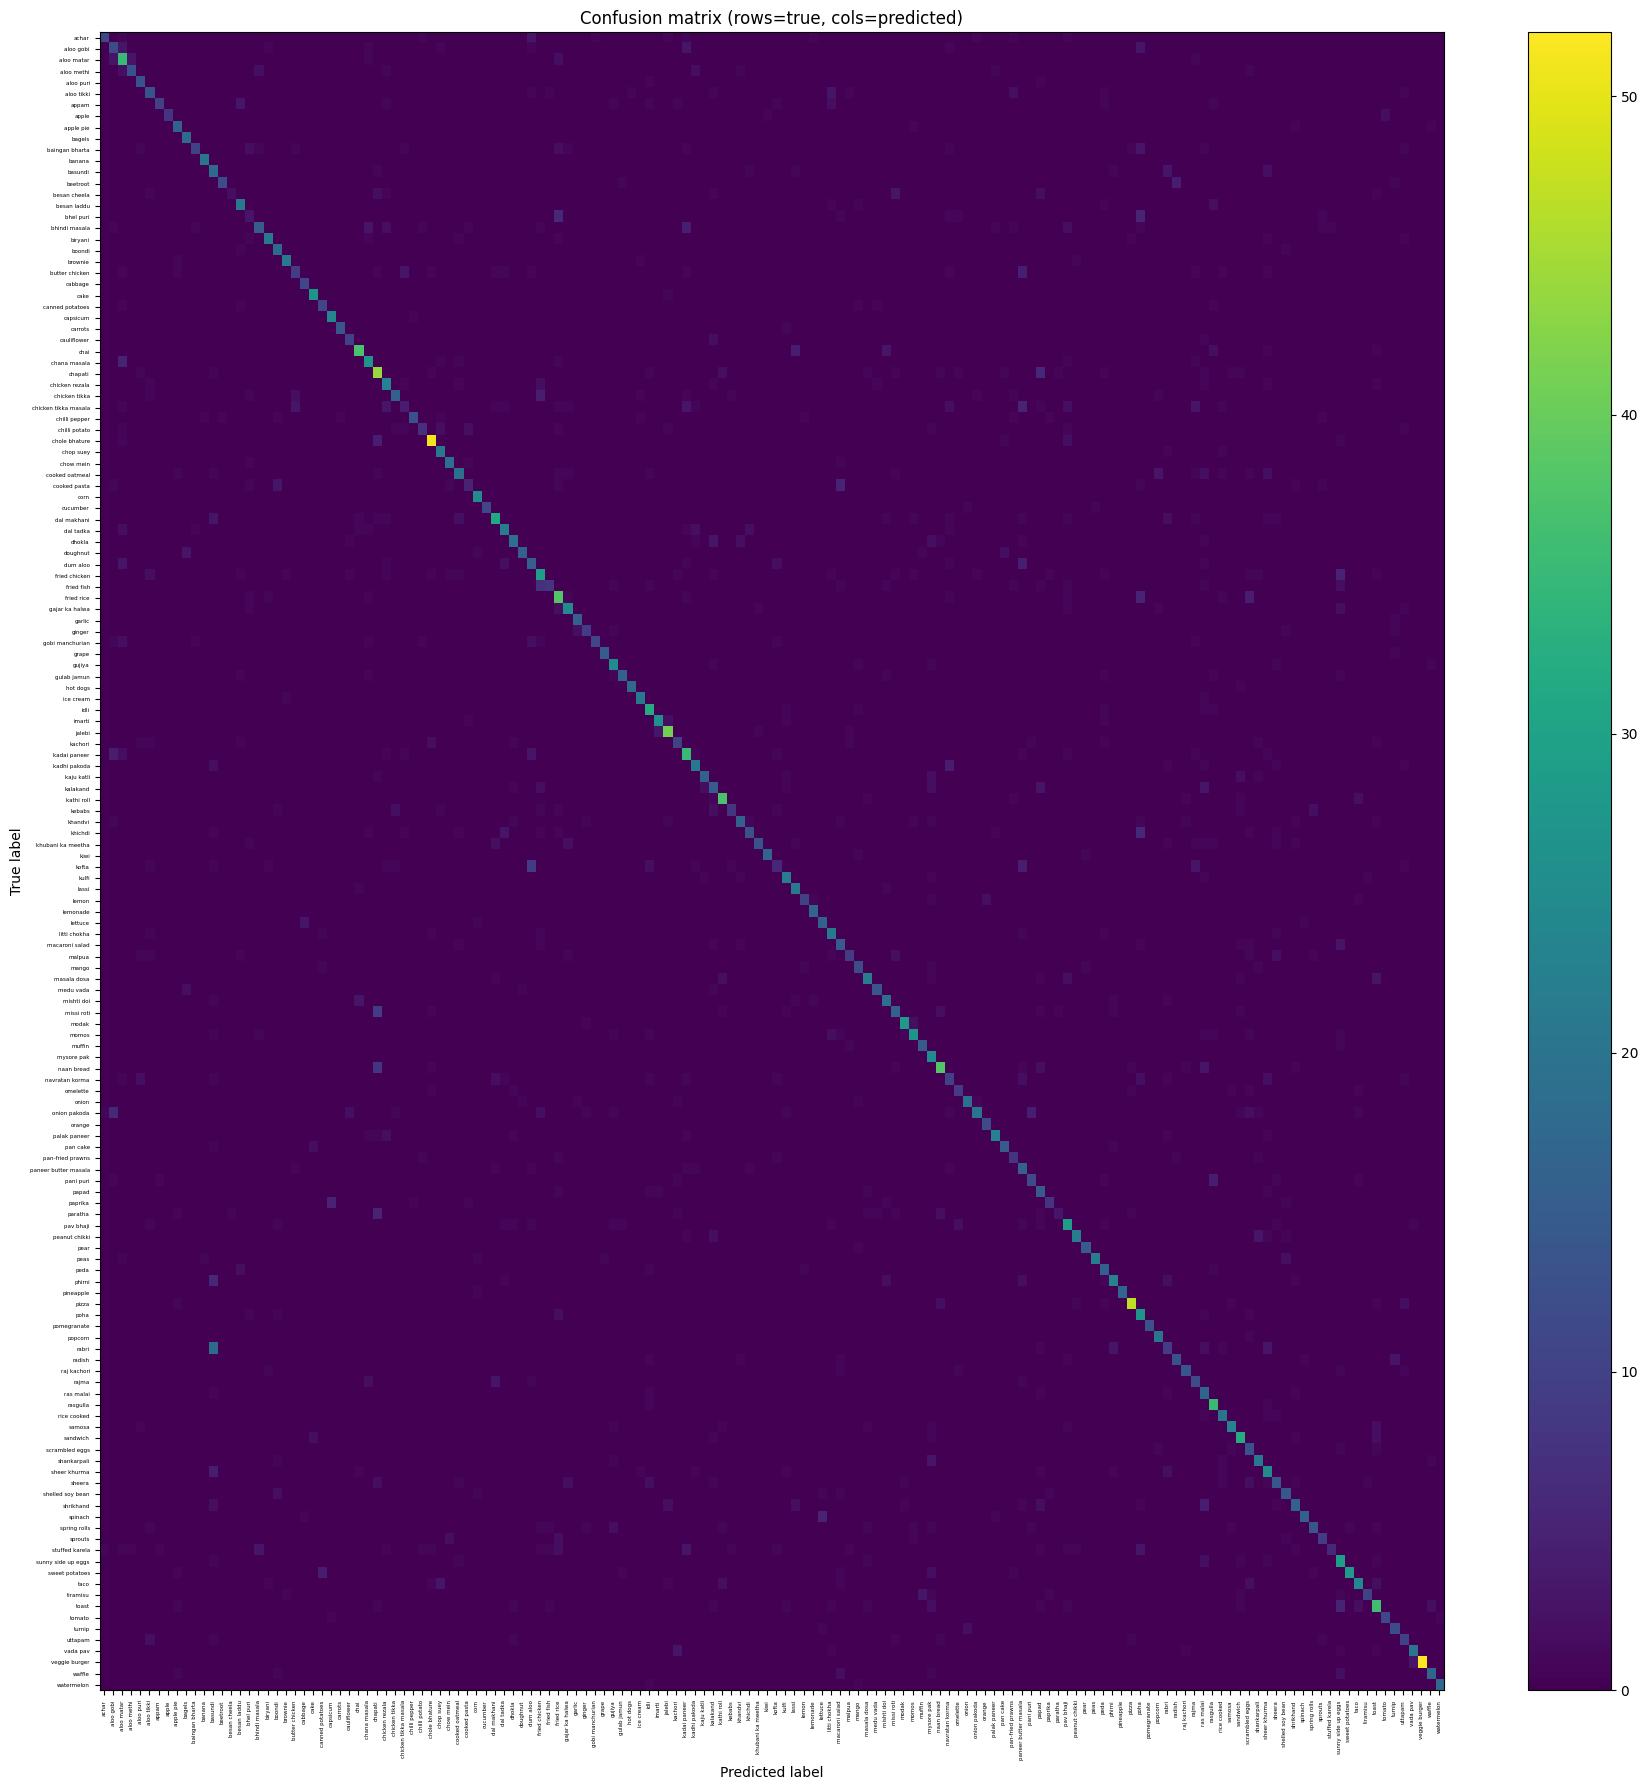


Top 10 most common confusions (true -> predicted):
rabri -> basundi: 18 examples
kofta -> dum aloo: 9 examples
missi roti -> chapati: 9 examples
naan bread -> chapati: 8 examples
fried fish -> fried chicken: 7 examples
bhel puri -> fried rice: 6 examples
chapati -> papad: 6 examples
khichdi -> poha: 6 examples
onion pakoda -> aloo gobi: 6 examples
phirni -> basundi: 6 examples


In [55]:
cm = confusion_matrix(y_true, y_pred)

# For large number of classes the plot will be dense; we size dynamically.
n = len(class_names)
fig_size = (12, 12) if n <= 50 else (18, 18)
plt.figure(figsize=fig_size)
plt.imshow(cm, interpolation='nearest', aspect='auto')
plt.title('Confusion matrix (rows=true, cols=predicted)')
plt.colorbar()
ticks = np.arange(n)
# reduce font size for many classes
fontsize = 8 if n <= 30 else (6 if n <= 80 else 4)
plt.xticks(ticks, class_names, rotation=90, fontsize=fontsize)
plt.yticks(ticks, class_names, fontsize=fontsize)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

# Additionally, print top confused pairs (true -> predicted) with highest counts (excluding diagonal)
import itertools
confusions = []
for i, j in itertools.product(range(n), range(n)):
    if i == j:
        continue
    confusions.append(((class_names[i], class_names[j]), cm[i, j]))
confusions_sorted = sorted(confusions, key=lambda x: x[1], reverse=True)
print("\nTop 10 most common confusions (true -> predicted):")
for (true_name, pred_name), cnt in confusions_sorted[:10]:
    if cnt > 0:
        print(f"{true_name} -> {pred_name}: {cnt} examples")
